# M2 Agentic AI - 图表生成

欢迎来到Agentic AI课程！在这个非评分实验以及后续课程中的实验里，你可以试着运行代码示例，实践视频里讲到的概念和设计模式。

把这些实验当成沙盒吧：一个安全的练习场所，让你更深入理解课程内容，增强信心，为后面有评分的练习做好准备。每个实验里，试着运行代码单元，看看智能代理工作流程是怎么运作的，更好地理解它们。

有些地方会鼓励你修改代码，比如换换提示语，试试不同的LLM，或者给工作流程加点额外查询。大胆试试，看看改动会怎么影响工作流程的表现。

最重要的是，非评分实验让你能按自己的节奏学习，亲自动手体验Agentic AI的核心理念。别忘了——你不是一个人在学！有问题随时去
社区问问。

1. 介绍
1.1. 实验概览

在这个非评分实验里，你将实现视频中介绍的反思模式，用在一个生成数据可视化的智能代理工作流程里。一个多模态LLM会审查第一版图表，找出可能的改进点——比如图表类型、标签或配色——然后重写图表生成代码，做出更有效的可视化。

视频里，Andrew展示了一个分析咖啡销售的工作流程。你将在这里用代码实现它。工作流程的步骤包括：

1. 生成初版（V1）：
用大型语言模型（LLM）生成第一版绘图代码。

2. 执行代码并生成图表：
运行生成的代码，展示结果图表。（全面检查）

3. 反思输出：
用大语言模型评估代码和图表，找出可以改进的地方（比如清晰度、准确性、设计等）。

4. 生成并执行改进版（V2）：
根据反思结果，写出更好的绘图代码，并展示优化后的图表。



🎯 1.2. 学习目标

完成本实验后，你将学会用代码实现反思模式，并用它来提升数据可视化效果。

## 初始化环境和客户端

这一步，你要导入支持工作流程的关键库：

- `re`：Python 的正则表达式模块，用来从 LLM 的输出中提取代码片段或结构化文本。
- `json`：提供读写 JSON 的函数，方便处理 LLM 返回的结构化响应。
- `utils`：这个实验提供的自定义辅助模块，包含处理数据集、生成图表和以清晰易读的格式展示结果的工具函数。

In [20]:
# Standard library imports
import re
import json

# Local helper module
import utils

## 加载数据集

Let’s take a look at the coffee sales data to see what information is contained in the file.

我们来看看咖啡销售数据，看看文件里有什么信息。

In [21]:
# 使用此 utils.py 函数将数据加载到数据框中
df = utils.load_and_prepare_data('coffee_sales.csv')

# 随机获取一个样本以显示
utils.print_html(df.sample(n=5), title="Random Sample of Coffee Sales Data")

date,time,cash_type,card,price,coffee_name,quarter,month,year
2024-09-09,08:30,card,ANON-0000-0000-0570,3.282,Latte,3,9,2024
2024-05-28,08:41,card,ANON-0000-0000-0097,3.282,Americano with Milk,2,5,2024
2024-11-18,16:49,card,ANON-0000-0000-0925,3.576,Latte,4,11,2024
2024-03-26,15:34,card,ANON-0000-0000-0009,3.870,Hot Chocolate,1,3,2024
2025-02-10,11:31,card,ANON-0000-0000-1199,3.576,Latte,1,2,2025


You’ll build an agentic workflow that generates data visualizations from this dataset, helping you answer questions about coffee sales from the vending machine.

你会搭建一个智能工作流，从这个数据集中生成数据可视化，帮你解答关于自动售货机咖啡销售的问题。

## 构建流水线

### 第1步 — 生成代码创建图表（V1）

这一步，你会让大语言模型写Python代码，根据用户关于咖啡数据集的查询生成图表。数据集里有`date`、`coffeetype`、`quantity`和`revenue`这些字段，你会把这些字段信息告诉模型，让它知道有哪些数据。

你要问模型的问题跟课上用的一样：
“用coffeesales.csv里的数据，画个图对比2024年和2025年第一季度的咖啡销量。”

模型输出的是用matplotlib库写的Python代码。代码不会直接显示图表，而是写在``标签里，方便后面步骤提取运行。关于这些标签，后面模块3会详细讲。

In [22]:
def generate_chart_code(instruction: str, model: str, out_path_v1: str) -> str:
    """Generate Python code to make a plot with matplotlib using tag-based wrapping."""

    prompt = f"""
    You are a data visualization expert.

    Return your answer *strictly* in this format:

    <execute_python>
    # valid python code here
    </execute_python>

    Do not add explanations, only the tags and the code.

    The code should create a visualization from a DataFrame 'df' with these columns:
    - date (M/D/YY)
    - time (HH:MM)
    - cash_type (card or cash)
    - card (string)
    - price (number)
    - coffee_name (string)
    - quarter (1-4)
    - month (1-12)
    - year (YYYY)

    User instruction: {instruction}

    Requirements for the code:
    1. Assume the DataFrame is already loaded as 'df'.
    2. Use matplotlib for plotting.
    3. Add clear title, axis labels, and legend if needed.
    4. Save the figure as '{out_path_v1}' with dpi=300.
    5. Do not call plt.show().
    6. Close all plots with plt.close().
    7. Add all necessary import python statements

    Return ONLY the code wrapped in <execute_python> tags.

    Finally, output the result in Chinese.
    """

    response = utils.get_response(model, prompt)
    return response

Now, try out the function and analyze the response!

现在，试用该功能并分析响应结果！

In [23]:
# 生成初始代码
code_v1 = generate_chart_code(
    instruction="使用 coffee_sales.csv 中的数据创建一个图表，比较2024年和2025年第一季度所有咖啡品种的销售情况。",
    model="gemini-3-flash-preview",
    out_path_v1="chart_v1.png"
)

utils.print_html(code_v1, title="LLM output with first draft code")

Great! You've generated some python code to create a chart! 

Notice that the code is wrapped between `<execute_python>` tags. These tags make it easy to automatically extract and run the code in the next step of the workflow.  

You don’t need to worry about the details yet — you’ll learn more about how these tags work in **Module 3**.  

太棒了！你已经生成了一些用于创建图表的 Python 代码！

请注意，代码被包裹在 `<execute_python>` 标签之间。这些标签使得在工作流程的下一步中自动提取和运行代码变得非常方便。

你暂时不需要担心细节——你将在模块3中详细了解这些标签的工作原理。

### 第2步 — 执行代码并创建图表

在这一步中，您将使用正则表达式提取上一阶段由大语言模型生成的Python代码（位于`python>`标签之间的部分）。提取后，您将运行这段代码以生成初稿图表。

具体操作如下：

1. 提取代码：
   使用正则表达式匹配并获取包裹在`python>`标签内的代码。

2. 执行代码：
   在预定义的全局环境中运行提取的代码，该环境中已预先加载了DataFrame `df`。这意味着您的代码可以直接使用`df`，无需重新加载数据集。

3. 生成图表：
   如果代码执行成功，将创建一个图表并保存为`chartv1.png`。

4. 在笔记本中查看图表：
   使用`utils.printhtml`将保存的图表内嵌显示，方便您直接查看结果。

完成此步骤后，您将获得第一版可视化图表（V1）——这是反思工作流程中的一个重要里程碑！


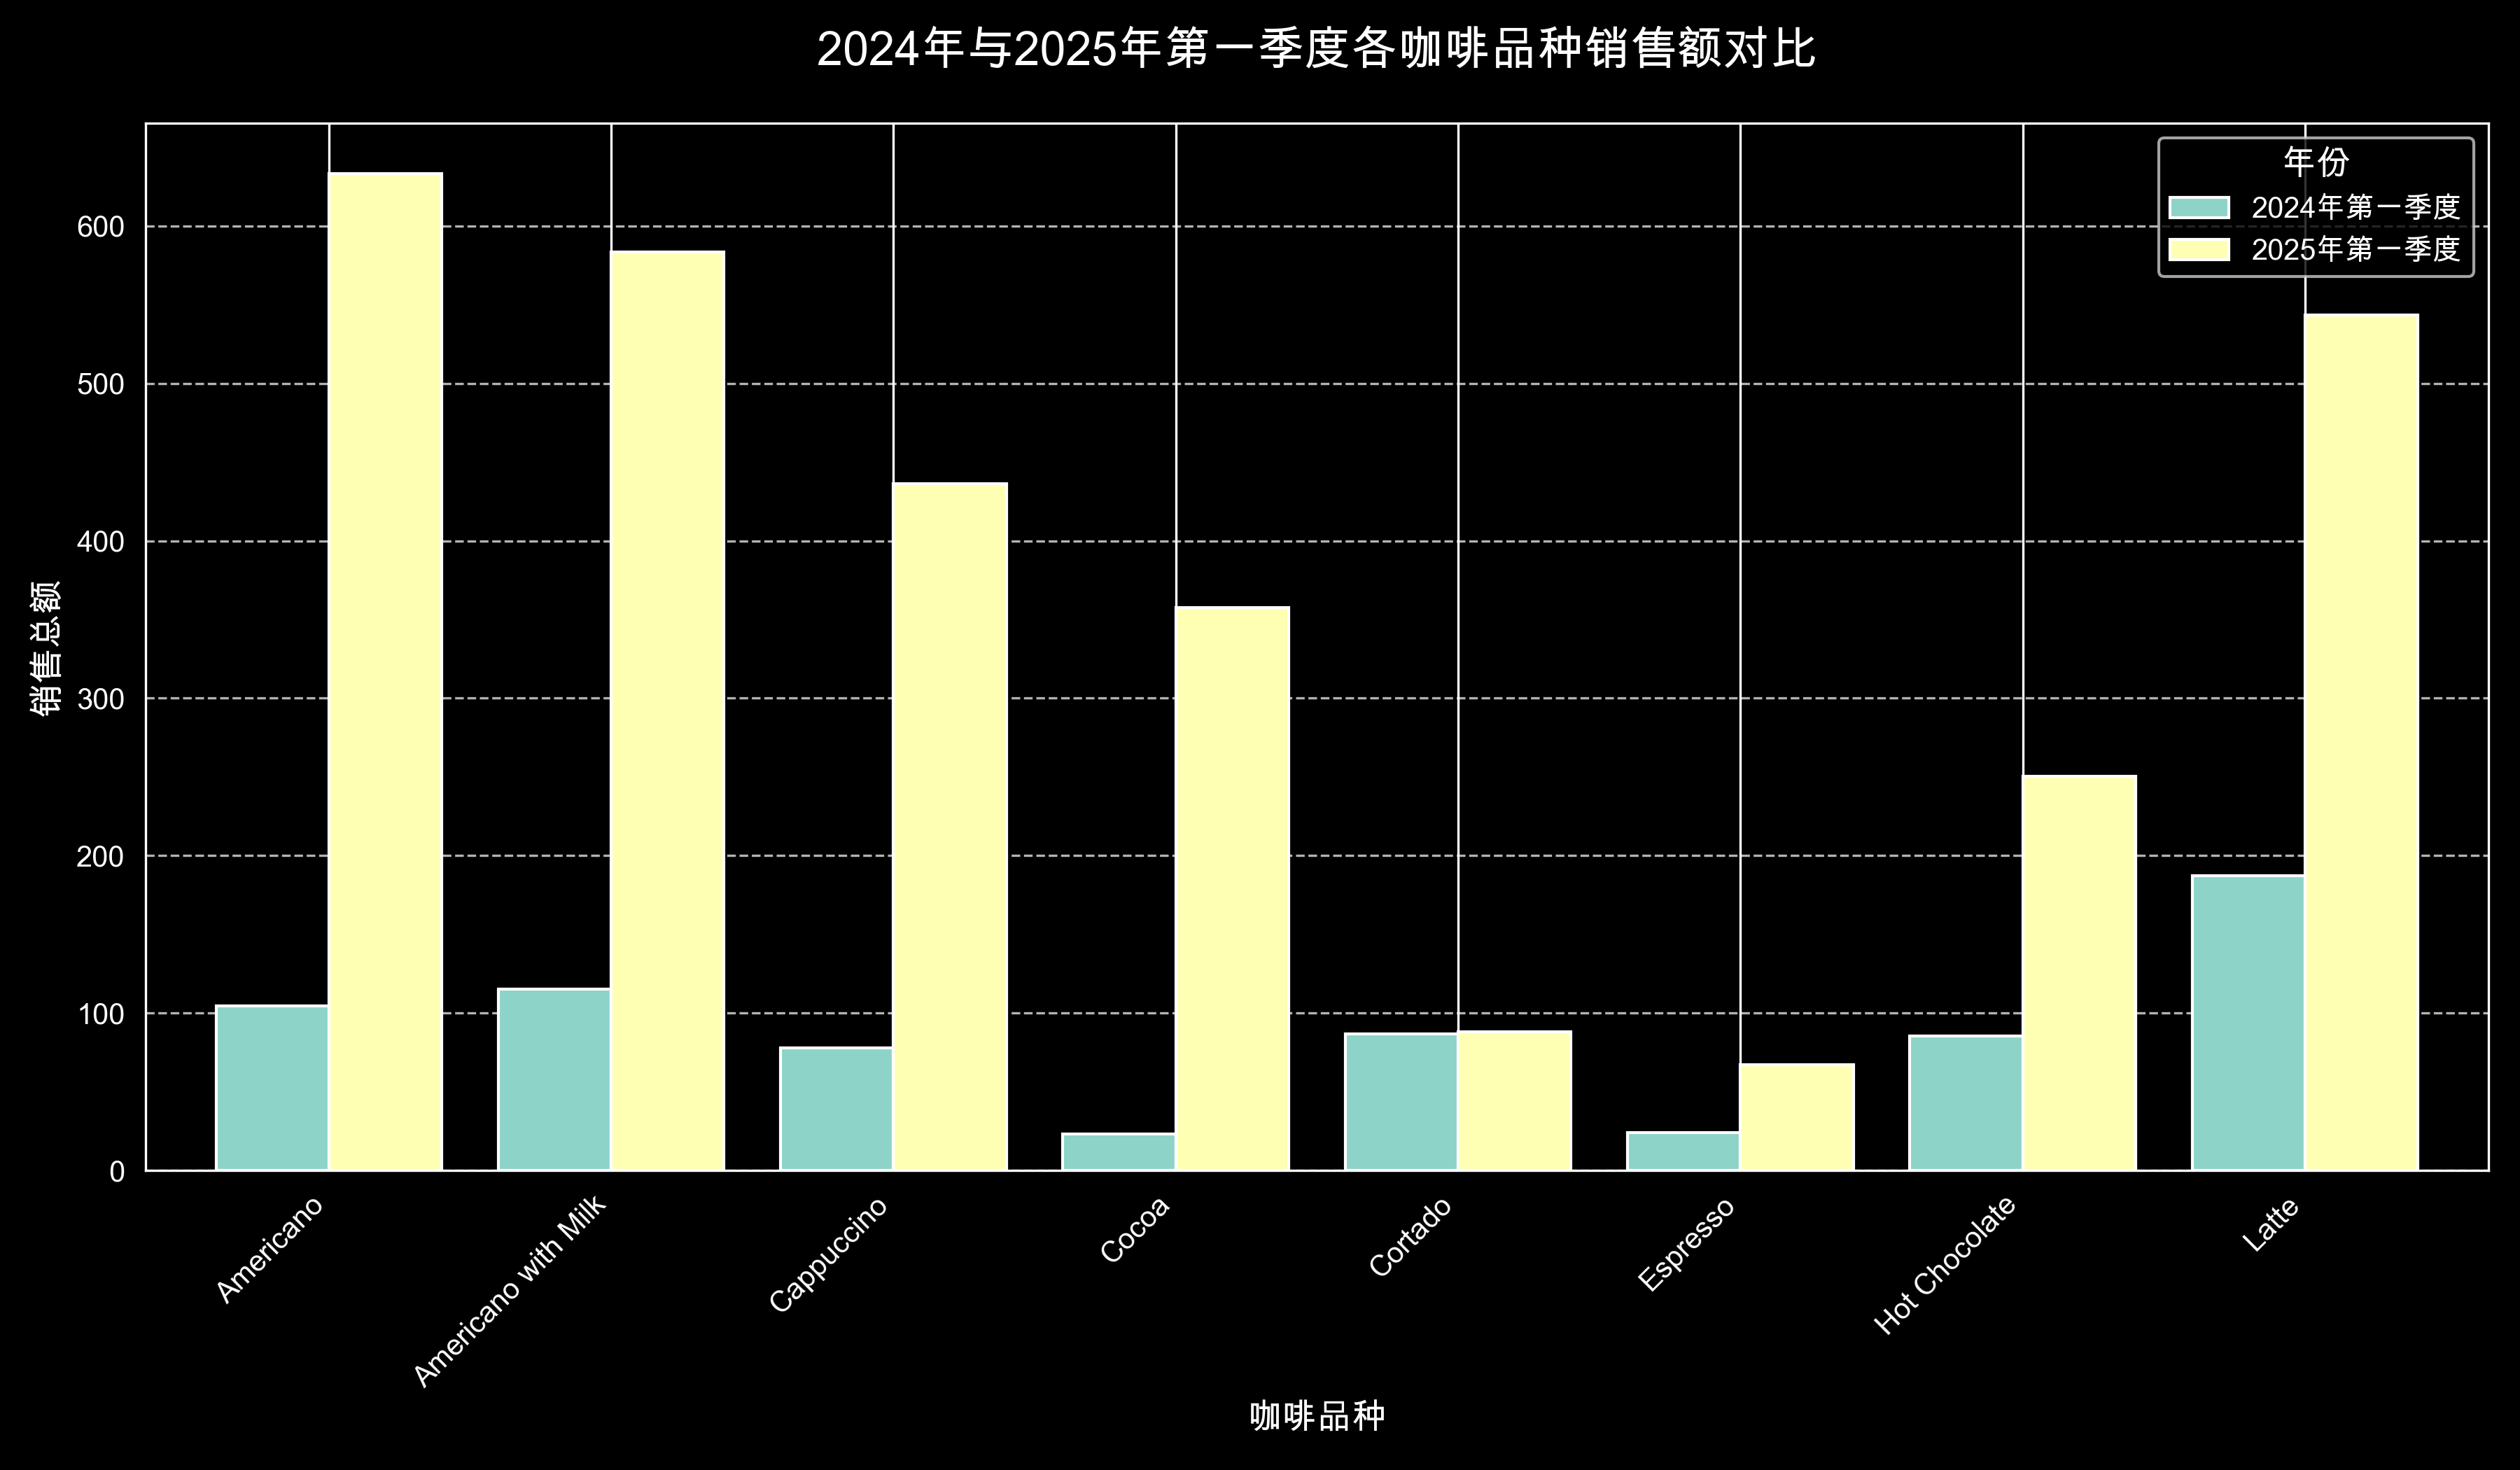

In [24]:
# 在标签中获取代码<execute_python>
match = re.search(r"<execute_python>([\s\S]*?)</execute_python>", code_v1)
if match:
    initial_code = match.group(1).strip()
    utils.print_html(initial_code, title="Extracted Code to Execute")
    exec_globals = {"df": df}
    exec(initial_code, exec_globals)

# 如果代码成功运行，文件 chart_v1.png 应该已经生成
utils.print_html(
    content="chart_v1.png",
    title="Generated Chart (V1)",
    is_image=True
)

### 第三步 — 反思输出

这里的目标是模拟人类如何审阅图表的初稿——寻找优点、缺点以及改进空间。

具体流程如下：

1. 将图表提供给大语言模型（LLM）：
生成的图表（chart_v1.png）会分享给LLM，使其能够“看到”该可视化内容。

2. 视觉分析图表：
LLM 会审查图表的清晰度、标签、准确性以及整体可读性等元素。

3. 生成反馈：
LLM 会提出改进建议，例如修正坐标轴标签、调整图表类型、优化配色方案或突出缺失的图例。

通过此过程，您创建了一个智能反馈环路，图表不仅仅是一次性生成，而是被积极批评——为更强大的第二版（V2）奠定基础。

In [25]:
def reflect_on_image_and_regenerate(
    chart_path: str,
    instruction: str,
    model_name: str,
    out_path_v2: str,
    code_v1: str,  
) -> tuple[str, str]:
    """
    Critique the chart IMAGE and the original code against the instruction, 
    then return refined matplotlib code.
    Returns (feedback, refined_code_with_tags).
    Supports OpenAI and Anthropic (Claude).
    """
    media_type, b64 = utils.encode_image_b64(chart_path)
    

    prompt = f"""
    You are a data visualization expert.
    Your task: critique the attached chart and the original code against the given instruction,
    then return improved matplotlib code.

    Original code (for context):
    {code_v1}

    OUTPUT FORMAT (STRICT):
    1) First line: a valid JSON object with ONLY the "feedback" field.
    Example: {{"feedback": "The legend is unclear and the axis labels overlap."}}

    2) After a newline, output ONLY the refined Python code wrapped in:
    <execute_python>
    ...
    </execute_python>

    3) Import all necessary libraries in the code. Don't assume any imports from the original code.

    HARD CONSTRAINTS:
    - Do NOT include Markdown, backticks, or any extra prose outside the two parts above.
    - Use pandas/matplotlib only (no seaborn).
    - Assume df already exists; do not read from files.
    - Save to '{out_path_v2}' with dpi=300.
    - Always call plt.close() at the end (no plt.show()).
    - Include all necessary import statements.

    Schema (columns available in df):
    - date (M/D/YY)
    - time (HH:MM)
    - cash_type (card or cash)
    - card (string)
    - price (number)
    - coffee_name (string)
    - quarter (1-4)
    - month (1-12)
    - year (YYYY)

    Instruction:
    {instruction}
    """


    # ✅ Use the safe helper that joins all text blocks and adds a system prompt
    content = utils.image_gemini_call(model_name, prompt, media_type, b64)

    # --- Parse ONLY the first JSON line (feedback) ---
    lines = content.strip().splitlines()
    json_line = lines[0].strip() if lines else ""

    try:
        obj = json.loads(json_line)
    except Exception as e:
        # Fallback: try to capture the first {...} in all the content
        m_json = re.search(r"\{.*?\}", content, flags=re.DOTALL)
        if m_json:
            try:
                obj = json.loads(m_json.group(0))
            except Exception as e2:
                obj = {"feedback": f"Failed to parse JSON: {e2}", "refined_code": ""}
        else:
            obj = {"feedback": f"Failed to find JSON: {e}", "refined_code": ""}

    # --- Extract refined code from <execute_python>...</execute_python> ---
    m_code = re.search(r"<execute_python>([\s\S]*?)</execute_python>", content)
    refined_code_body = m_code.group(1).strip() if m_code else ""
    refined_code = utils.ensure_execute_python_tags(refined_code_body)

    feedback = str(obj.get("feedback", "")).strip()
    return feedback, refined_code



Note that, the model is instructed to return its response in **JSON format**.  

- JSON is a lightweight, structured format (key–value pairs) that makes it easy to parse the LLM’s output programmatically.  
- Here, we require two fields:  
  - **`feedback`**: a short critique of the current chart.  
  - **`refined_code`**: an improved Python code snippet wrapped in `<execute_python>` tags.  

We also include a **“constraints” section** in the prompt. These rules (e.g., use matplotlib only, save the file to a specific path, call `plt.close()` at the end) help the model generate consistent, runnable code that fits the workflow. Without these constraints, the output might vary too much or include unwanted formatting.  


### 3.4 Step 4 — Generate and Execute Improved Version (V2)

In this final step, it’s time to generate and run the improved version of the chart (V2).  
After running the cell, you’ll see **both the reflection written by the LLM** (explaining what needed improvement) **and the new code it generated**. The new code will then be executed to produce the updated chart.  

In [28]:
# Generate feedback alongside reflected code
feedback, code_v2 = reflect_on_image_and_regenerate(
    chart_path="chart_v1.png",            
    instruction="Create a plot comparing Q1 coffee sales in 2024 and 2025 using the data in coffee_sales.csv.", 
    model_name="gemini-3-flash-preview",
    out_path_v2="chart_v2.png",
    code_v1=code_v1,   # pass in the original code for context        
)

utils.print_html(feedback, title="Feedback on V1 Chart")
utils.print_html(code_v2, title="Regenerated Code Output (V2)")

Now you’ll execute the refined code returned by the reflection step.  The code inside the `<execute_python>` tags is extracted, run against the dataset, and used to generate the updated chart.  

If the execution is successful, you’ll see the new image (`chart_v2.png`) displayed below as the **Regenerated Chart (V2)**.  

In [29]:
# Get the code within the <execute_python> tags
match = re.search(r"<execute_python>([\s\S]*?)</execute_python>", code_v2)
if match:
    reflected_code = match.group(1).strip()
    exec_globals = {"df": df}
    exec(reflected_code, exec_globals)

# If code run successfully, the file chart_v2.png should have been generated
utils.print_html(
    content="chart_v2.png",
    title="Regenerated Chart (V2)",
    is_image=True
)

FileNotFoundError: [Errno 2] No such file or directory: 'chart_v2.png'

### 4. Put it all together — creating the end-to-end workflow

Now it’s time to wrap everything into a single automated workflow the agent can run from start to finish.

The `run_workflow` function links together the components you implemented earlier:

1) **Load and prepare data** — via `utils.load_and_prepare_data(...)`.  
2) **Generate V1 code** — with `generate_chart_code(...)`, which returns the first-draft matplotlib code (wrapped in `<execute_python>` tags).  
3) **Execute V1 immediately** — the workflow extracts the code between `<execute_python>` tags and runs it to produce the first chart image.  
4) **Reflect and refine** — `reflect_on_image_and_regenerate(...)` critiques the V1 image (and the original code) against the instruction, returns concise **feedback** plus **revised code (V2)**.  
5) **Execute V2 immediately** — the refined code is extracted and executed to generate the improved chart.

### What this workflow accepts
- **`dataset_path`**: location of the input CSV.  
- **`user_instructions`**: the chart request (e.g., “Create a plot comparing Q1 coffee sales in 2024 and 2025 using the data in coffee_sales.csv.”).  
- **`generation_model`**: model used for the initial code generation.  
- **`reflection_model`**: model used for the image-based reflection and code refinement.  
- **`image_basename`**: base filename for saving chart images (e.g., `chart_v1.png`, `chart_v2.png`).  

> Note: The chart execution steps are intentionally **hard-coded** to run right after code generation/refinement. This mirrors the workflow in the lecture and ensures you see each draft’s output before moving on.


In [ ]:
def run_workflow(
    dataset_path: str,
    user_instructions: str,
    generation_model: str,
    reflection_model: str,   
    image_basename: str = "chart",
):
    """
    End-to-end pipeline:
      1) load dataset
      2) generate V1 code
      3) execute V1 → produce chart_v1.png
      4) reflect on V1 (image + original code) → feedback + refined code
      5) execute V2 → produce chart_v2.png

    Returns a dict with all artifacts (codes, feedback, image paths).
    """
    # 0) Load dataset; utils handles parsing and feature derivations (e.g., year/quarter)
    df = utils.load_and_prepare_data(dataset_path)
    utils.print_html(df.sample(n=5), title="Random Sample of Dataset")

    # Paths to store charts
    out_v1 = f"{image_basename}_v1.png"
    out_v2 = f"{image_basename}_v2.png"

    # 1) Generate code (V1)
    utils.print_html("Step 1: Generating chart code (V1)… 📈")
    code_v1 = generate_chart_code(
        instruction=user_instructions,
        model=generation_model,
        out_path_v1=out_v1,
    )
    utils.print_html(code_v1, title="LLM output with first draft code (V1)")

    # 2) Execute V1 (hard-coded: extract <execute_python> block and run immediately)
    utils.print_html("Step 2: Executing chart code (V1)… 💻")
    match = re.search(r"<execute_python>([\s\S]*?)</execute_python>", code_v1)
    if match:
        initial_code = match.group(1).strip()
        exec_globals = {"df": df}
        exec(initial_code, exec_globals)
    utils.print_html(out_v1, is_image=True, title="Generated Chart (V1)")

    # 3) Reflect on V1 (image + original code) to get feedback and refined code (V2)
    utils.print_html("Step 3: Reflecting on V1 (image + code) and generating improvements… 🔁")
    feedback, code_v2 = reflect_on_image_and_regenerate(
        chart_path=out_v1,
        instruction=user_instructions,
        model_name=reflection_model,
        out_path_v2=out_v2,
        code_v1=code_v1,  # pass original code for context
    )
    utils.print_html(feedback, title="Reflection feedback on V1")
    utils.print_html(code_v2, title="LLM output with revised code (V2)")

    # 4) Execute V2 (hard-coded: extract <execute_python> block and run immediately)
    utils.print_html("Step 4: Executing refined chart code (V2)… 🖼️")
    match = re.search(r"<execute_python>([\s\S]*?)</execute_python>", code_v2)
    if match:
        reflected_code = match.group(1).strip()
        exec_globals = {"df": df}
        exec(reflected_code, exec_globals)
    utils.print_html(out_v2, is_image=True, title="Regenerated Chart (V2)")

    return {
        "code_v1": code_v1,
        "chart_v1": out_v1,
        "feedback": feedback,
        "code_v2": code_v2,
        "chart_v2": out_v2,
    }


### 4.2. Try the workflow

Now it’s your turn to put the full workflow into action with the updated example from the lecture.

- **Instruction to use:**  
  “Create a plot comparing Q1 coffee sales in 2024 and 2025 using the data in coffee_sales.csv.”

When you run the workflow with this instruction, it will:
1. Generate first-draft code to create the chart.  
2. Execute that code immediately to produce the first version of the chart (V1).  
3. Reflect on the chart and the original code, producing feedback and revised code (V2).  
4. Execute the refined code to generate the improved chart (V2).  

### Customize and experiment

After trying the example above, feel free to update the `user_instructions` parameter with your own chart prompts.  
Remember to also adjust the `image_basename` so each run saves its results under a new filename — this keeps your charts organized and avoids overwriting previous outputs.

### Choosing models

You can mix and match different models for generation and reflection. For example:
- Use a fast model for initial code generation (`gemini-2.0-flash`).  
- Use a stronger reasoning model for reflection (`gemini-1.5-pro`).  

This flexibility lets you explore trade-offs between speed and quality.

👉 **Call to action:** Run the workflow now with the example instruction from the lecture. Then experiment with your own prompts to see how the agent adapts!

In [ ]:
# Here, insert your updates
user_instructions="Create a plot comparing Q1 coffee sales in 2024 and 2025 using the data in coffee_sales.csv." # write your instruction here
generation_model="gemini-3-flash-preview"
reflection_model="gemini-3-flash-preview"
image_basename="drink_sales"

# Run the complete agentic workflow
_ = run_workflow(
    dataset_path="coffee_sales.csv",
    user_instructions=user_instructions,
    generation_model=generation_model,
    reflection_model=reflection_model,
    image_basename=image_basename
)

## 5. Final Takeaways

In this lab, **you** practiced using reflection to improve chart outputs.
You learned to:

* Generate an initial chart (V1).
* Critique and refine it into a better version (V2).
* Automate the full workflow with different models.

The key idea: reflection helps **you** create clearer, more accurate, and more effective visualizations.


<div style="border:1px solid #22c55e; border-left:6px solid #16a34a; background:#dcfce7; border-radius:6px; padding:14px 16px; color:#064e3b; font-family:system-ui,-apple-system,Segoe UI,Roboto,Ubuntu,Cantarell,Noto Sans,sans-serif;">

🎉 <strong>Congratulations!</strong>  

You’ve completed the lab on building an **agentic chart generation workflow**.  
Along the way, **you** practiced generating charts, reflecting on their quality, and refining them into clearer and more effective visualizations.  

With these skills, **you** are ready to design agentic pipelines that create data visualizations automatically while keeping them accurate, explainable, and polished. 🌟  

</div>

